In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import backend as K

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

K.clear_session()

In [3]:
DATA_PATH = 'D:/Infared_Solar_Paper/InfraredSolarModules/images'
METADATA_PATH = r"D:/Infared_Solar_Paper/InfraredSolarModules/module_metadata.json"

In [4]:
df = pd.read_json(METADATA_PATH, orient='index')

In [5]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
df['image_filepath'] = [os.path.join(DATA_PATH, x) for x in df['image_filepath']]

In [7]:
df['anomaly_class'].value_counts()

anomaly_class
No-Anomaly        10000
Cell               1877
Vegetation         1639
Diode              1499
Cell-Multi         1288
Shadowing          1056
Cracking            940
Offline-Module      827
Hot-Spot            249
Hot-Spot-Multi      246
Soiling             204
Diode-Multi         175
Name: count, dtype: int64

In [8]:
count=df['anomaly_class'].value_counts()

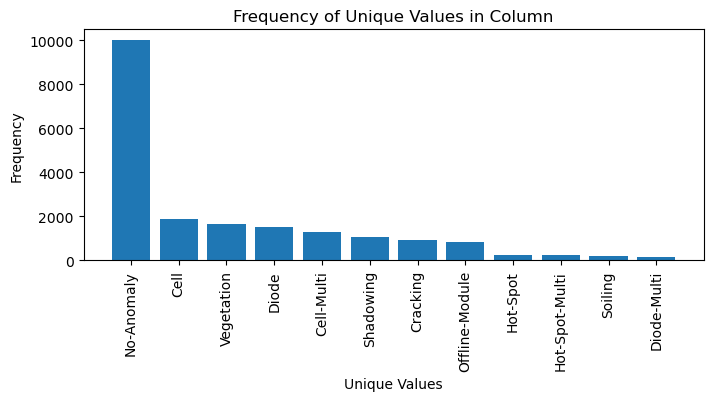

In [9]:
plt.figure(figsize=(8,3))
plt.bar(count.index, count.values,)

plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.title('Frequency of Unique Values in Column')
plt.xticks(rotation=90) 
plt.show()

In [10]:
from pathlib import Path
import json
import os

# Define paths
base_path = Path(r"D:/Infared_Solar_Paper/InfraredSolarModules/images")
METADATA_PATH = r"D:/Infared_Solar_Paper/InfraredSolarModules/module_metadata.json"

# Load and clean metadata
with open(METADATA_PATH, 'r') as f:
    raw_data = json.load(f)
    for key, value in raw_data.items():
        value['image_filepath'] = os.path.basename(value['image_filepath']).encode('ascii', errors='ignore').decode('ascii')

df = pd.DataFrame.from_dict(raw_data, orient='index')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df['image_filepath'] = df['image_filepath'].apply(lambda x: str(base_path / x))

# Validate paths
invalid_paths = df['image_filepath'][~df['image_filepath'].apply(os.path.exists)]
if not invalid_paths.empty:
    print(f"Warning: {len(invalid_paths)} invalid file paths found:")
    print(invalid_paths.head())
df = df[df['image_filepath'].apply(os.path.exists)]

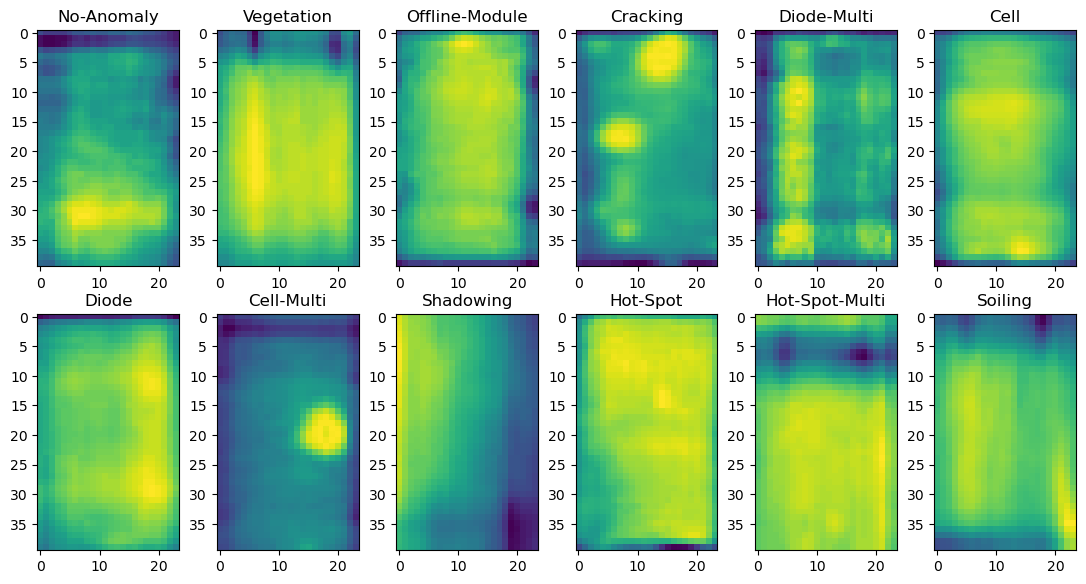

In [11]:
#Lets's see the anomalities pic   #took an inspiration for this from one of the kaggle notebook
classes = df['anomaly_class'].unique()
plt.figure(figsize=(13.5, 21.5))

for i, class_name in enumerate(classes, start=1):
    sample = df[df['anomaly_class'] == class_name].sample(n=1).iloc[0]
    
    image = cv2.imread(sample['image_filepath'], 0)
    
    plt.subplot(6, 6, i)
    plt.imshow(image)
    plt.title(class_name)

plt.show()

In [12]:
x=df.iloc[:,0]
y=df.iloc[:,1]

In [13]:
label_encoder = LabelEncoder()        #Encoding the data
y_enco = label_encoder.fit_transform(y)

In [14]:
from imblearn.over_sampling import SMOTE

In [15]:
train = []
for i in df['image_filepath']:
    img = cv2.imread(i)
    img = np.array(img)
    train.append(img)

Converting the images to array format

In [16]:
train = np.array(train)

In [17]:
if len(train.shape) == 4:
    train = train.reshape(train.shape[0], -1)    #Changing to 2D data

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(train, y_enco)

In [18]:
if len(X_resampled.shape) == 2:
    X_resampled = X_resampled.reshape(X_resampled.shape[0], 40, 24, 3)

In [19]:
from tensorflow.keras.utils import to_categorical
train_o = to_categorical(y_resampled, num_classes=12)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled,train_o, test_size=0.2, random_state=42)

# Model Building

In [21]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Multiply

In [22]:
# Compute class weights for imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weight_dict = dict(enumerate(class_weights))

In [23]:
# Define focal loss
def focal_loss_fn(y_true, y_pred, gamma=2.0):
    y_pred = tf.nn.softmax(y_pred)
    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False)
    p_t = tf.reduce_sum(y_true * y_pred, axis=-1)
    focal_weight = tf.pow(1.0 - p_t, gamma)
    alpha = tf.constant([class_weight_dict[i] for i in range(12)], dtype=tf.float32)
    alpha_t = tf.reduce_sum(y_true * alpha, axis=-1)
    focal_loss = alpha_t * focal_weight * ce_loss
    return tf.reduce_mean(focal_loss)

In [24]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomBrightness(0.2),
])

In [27]:
from tensorflow.keras.layers import Add, Input, Activation, Dense, Reshape, Multiply, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate, GlobalMaxPooling2D, Conv2D, BatchNormalization, MaxPool2D

def dual_attention_block(x, ratio=8):
    """Dual Attention: Channel and Spatial executed in parallel then combined."""
    _, h, w, c = x.shape
    
    # Channel Attention (same as your CA part)
    avg_pool = GlobalAveragePooling2D(keepdims=True)(x)
    max_pool = GlobalMaxPooling2D(keepdims=True)(x)
    channel_attention = Add()([avg_pool, max_pool])
    channel_attention = Conv2D(c//ratio, 1, activation='relu')(channel_attention)
    channel_attention = Conv2D(c, 1, activation='sigmoid')(channel_attention)
    
    # Spatial Attention (simplified)
    spatial_avg = tf.reduce_mean(x, axis=-1, keepdims=True)
    spatial_max = tf.reduce_max(x, axis=-1, keepdims=True)
    spatial_attention = Concatenate(axis=-1)([spatial_avg, spatial_max])
    spatial_attention = Conv2D(1, 7, padding='same', activation='sigmoid')(spatial_attention)
    
    # Combine attentions
    x = Multiply()([x, channel_attention])
    x = Multiply()([x, spatial_attention])
    
    return x

def sk_convolution(x, filters, ratio=16):
    """Selective Kernel convolution for adaptive receptive field selection."""
    # Multi-branch convolution
    branch3x3 = Conv2D(filters, 3, padding='same', activation='relu')(x)
    branch5x5 = Conv2D(filters, 5, padding='same', activation='relu')(x)
    
    # Fusion and attention
    fused = Add()([branch3x3, branch5x5])
    squeezed = GlobalAveragePooling2D(keepdims=True)(fused)
    
    # Channel attention for branch selection
    fc1 = Dense(filters//ratio, activation='relu')(squeezed)
    attention_weights = Dense(filters*2, activation='softmax')(fc1)  # For two branches
    
    # Apply attention weights
    attention_weights = Reshape((1, 1, filters, 2))(attention_weights)
    branch3x3_weighted = branch3x3 * attention_weights[..., 0]
    branch5x5_weighted = branch5x5 * attention_weights[..., 1]
    
    return Add()([branch3x3_weighted, branch5x5_weighted])

def improved_residual_block(x, filters, strides=1):
    """Enhanced residual block with pre-activation and better gradient flow."""
    shortcut = x
    
    # Pre-activation design
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, strides=strides, padding='same')(x)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    
    # Shortcut connection
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, strides=strides)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    return Add()([x, shortcut])

In [28]:
def enhanced_solar_model(input_shape=(40, 24, 3), num_classes=12):
    inputs = Input(shape=input_shape)
    
    # Initial processing
    x = Conv2D(32, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Stage 1
    x = improved_residual_block(x, 32)
    x = improved_residual_block(x, 32)
    x = MaxPool2D(2)(x)
    
    # Stage 2
    x = improved_residual_block(x, 64, strides=1)
    x = improved_residual_block(x, 64)
    x = dual_attention_block(x)  # Strategic placement
    x = MaxPool2D(2)(x)
    
    # Stage 3
    x = improved_residual_block(x, 128)
    x = improved_residual_block(x, 128)
    x = sk_convolution(x, 128)  # Multi-scale processing
    x = MaxPool2D(2)(x)
    
    # Stage 4
    x = improved_residual_block(x, 256)
    x = improved_residual_block(x, 256)
    x = dual_attention_block(x)  # Final attention before classification
    
    # Multi-scale feature extraction
    branch1 = Conv2D(256, 1, activation='relu')(x)
    branch2 = Conv2D(256, 3, padding='same', activation='relu')(x)
    branch3 = Conv2D(256, 5, padding='same', activation='relu')(x)
    x = Concatenate()([branch1, branch2, branch3])
    
    # Classification head
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs, outputs)

## Training

In [29]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)  # Disable device logging

Num GPUs Available:  1


In [31]:
num_classes = 12

# Build and compile model
model = enhanced_solar_model()

# Advanced learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=100,
    t_mul=2.0,
    m_mul=0.9
)

# Label smoothing for better calibration
def smoothed_categorical_crossentropy(y_true, y_pred, smoothing=0.1):
    y_true = y_true * (1 - smoothing) + smoothing / num_classes
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)

# BEFORE you build/compile the model
try:
    # if you have tensorflow-addons installed
    from tensorflow_addons.optimizers import AdamW
    opt = AdamW(learning_rate=lr_schedule, weight_decay=1e-4)
except ImportError:
    # pip install tensorflow-addons  (in your env)
    # fallback: Adam + weight decay via L2 on layers
    from tensorflow.keras.optimizers import Adam
    opt = Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=opt,
    loss=smoothed_categorical_crossentropy,
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)]
)

# Train model
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-4)
]

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=500,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Epoch 1/500
3000/3000 [==============================] - 690s 228ms/step - loss: 1.8431 - accuracy: 0.4372 - top_k_categorical_accuracy: 0.7234 - val_loss: 1.2669 - val_accuracy: 0.6902 - val_top_k_categorical_accuracy: 0.9166
Epoch 2/500
3000/3000 [==============================] - 609s 203ms/step - loss: 1.2010 - accuracy: 0.7390 - top_k_categorical_accuracy: 0.9267 - val_loss: 0.8840 - val_accuracy: 0.8589 - val_top_k_categorical_accuracy: 0.9756
Epoch 3/500
3000/3000 [==============================] - 580s 193ms/step - loss: 0.9845 - accuracy: 0.8326 - top_k_categorical_accuracy: 0.9652 - val_loss: 0.8772 - val_accuracy: 0.8629 - val_top_k_categorical_accuracy: 0.9788
Epoch 4/500
3000/3000 [==============================] - 581s 194ms/step - loss: 0.7329 - accuracy: 0.9413 - top_k_categorical_accuracy: 0.9906 - val_loss: 0.6365 - val_accuracy: 0.9661 - val_top_k_categorical_accuracy: 0.9949
Epoch 5/500
3000/3000 [==============================] - 580s 193ms/step - loss: 0.7722 - ac

## Overfitting Analysis


=== Last epochs ===
 epoch   loss val_loss    acc val_acc   top3 val_top3
    17 0.5519   0.5406 0.9992  0.9964 0.9999   0.9994
    18 0.6191   0.7416 0.9750  0.9234 0.9961   0.9904
    19 0.5855   0.8683 0.9874  0.8847 0.9986   0.9749
    20 0.5808   0.5736 0.9889  0.9850 0.9989   0.9987
    21 0.5741   0.9718 0.9916  0.8586 0.9991   0.9657
    22 0.5716   0.5712 0.9923  0.9843 0.9992   0.9993
    23 0.5655   0.6793 0.9943  0.9465 0.9995   0.9905
    24 0.5625   0.5885 0.9952  0.9781 0.9995   0.9990
    25 0.5573   0.6315 0.9970  0.9624 0.9997   0.9974
    26 0.5552   0.5884 0.9974  0.9787 0.9998   0.9972

=== Generalization (last epoch) ===
Loss gap (val - train): 0.0333  -> overfit sign
Acc gap  (train-val) : 0.0187   -> ok
Top3 gap (train-val) : 0.0026  -> ok

=== Best epoch by val_loss ===
Epoch 16 | loss 0.5528 vs val_loss 0.5406 | acc 0.9990 vs val_acc 0.9965 | top3 0.9998 vs val_top3 0.9995

=== Top-5 epochs (lowest val_loss) ===
 epoch   loss val_loss    acc val_acc   top3 va

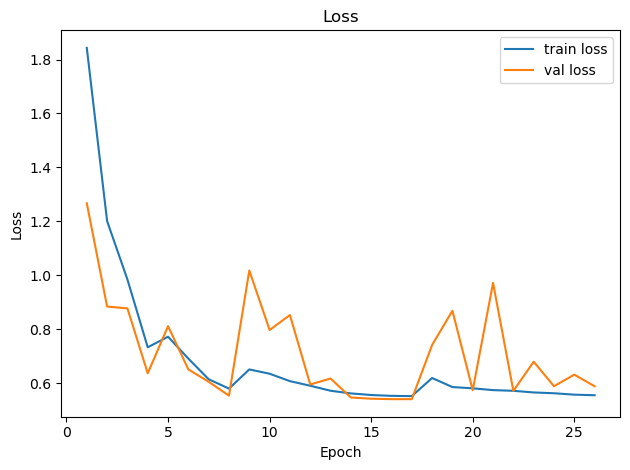

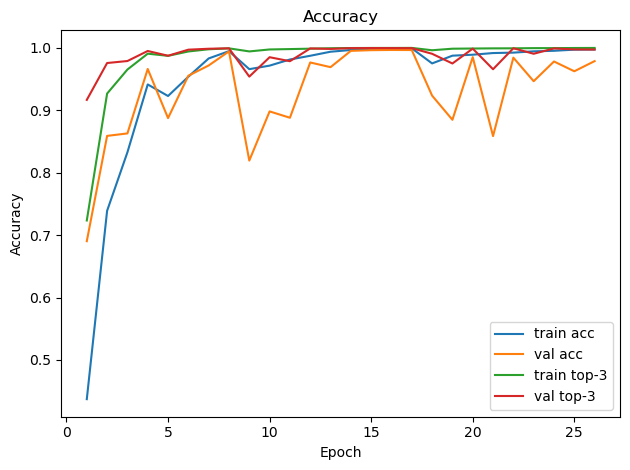

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Collect metrics from history
hist = history.history
epochs = np.arange(1, len(hist['loss'])+1)

def _get(name):
    # safe getter: returns NaNs if the metric wasn't logged
    return np.array(hist.get(name, [np.nan]*len(epochs)), dtype=float)

df_hist = pd.DataFrame({
    'epoch'   : epochs,
    'loss'    : _get('loss'),
    'val_loss': _get('val_loss'),
    'acc'     : _get('accuracy'),
    'val_acc' : _get('val_accuracy'),
    'top3'    : _get('top_k_categorical_accuracy'),
    'val_top3': _get('val_top_k_categorical_accuracy'),
})

# 2) Print the last 10 epochs (edit N as you like)
N = 10
print("\n=== Last epochs ===")
print(df_hist.tail(N).to_string(index=False, 
                                formatters={'loss': '{:.4f}'.format,
                                            'val_loss': '{:.4f}'.format,
                                            'acc': '{:.4f}'.format,
                                            'val_acc': '{:.4f}'.format,
                                            'top3': '{:.4f}'.format,
                                            'val_top3': '{:.4f}'.format}))

# 3) Overfitting diagnostics (gaps: train - val)
df_hist['acc_gap']   = df_hist['acc']   - df_hist['val_acc']
df_hist['top3_gap']  = df_hist['top3']  - df_hist['val_top3']
df_hist['loss_gap']  = df_hist['val_loss'] - df_hist['loss']  # >0 means val worse than train

last = df_hist.iloc[-1]
print("\n=== Generalization (last epoch) ===")
print(f"Loss gap (val - train): {last.loss_gap:.4f}  -> {'overfit sign' if last.loss_gap>0 else 'ok'}")
print(f"Acc gap  (train-val) : {last.acc_gap:.4f}   -> {'overfit sign' if last.acc_gap>0.02 else 'ok'}")
print(f"Top3 gap (train-val) : {last.top3_gap:.4f}  -> {'overfit sign' if last.top3_gap>0.02 else 'ok'}")

# 4) Best epoch by val_loss
best_idx = int(df_hist['val_loss'].idxmin())
best_row = df_hist.loc[best_idx]
print("\n=== Best epoch by val_loss ===")
print(f"Epoch {int(best_row.epoch)} | "
      f"loss {best_row.loss:.4f} vs val_loss {best_row.val_loss:.4f} | "
      f"acc {best_row.acc:.4f} vs val_acc {best_row.val_acc:.4f} | "
      f"top3 {best_row.top3:.4f} vs val_top3 {best_row.val_top3:.4f}")

# 5) Top-5 epochs by val_loss (quick sanity check)
print("\n=== Top-5 epochs (lowest val_loss) ===")
print(df_hist.nsmallest(5, 'val_loss')[['epoch','loss','val_loss','acc','val_acc','top3','val_top3']]
      .to_string(index=False, 
                 formatters={'loss': '{:.4f}'.format,'val_loss': '{:.4f}'.format,
                             'acc': '{:.4f}'.format,'val_acc': '{:.4f}'.format,
                             'top3': '{:.4f}'.format,'val_top3': '{:.4f}'.format}))

# 6) (Optional) Plots
plt.figure()
plt.plot(df_hist['epoch'], df_hist['loss'], label='train loss')
plt.plot(df_hist['epoch'], df_hist['val_loss'], label='val loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure()
plt.plot(df_hist['epoch'], df_hist['acc'], label='train acc')
plt.plot(df_hist['epoch'], df_hist['val_acc'], label='val acc')
plt.plot(df_hist['epoch'], df_hist['top3'], label='train top-3')
plt.plot(df_hist['epoch'], df_hist['val_top3'], label='val top-3')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy'); plt.legend(); plt.tight_layout(); plt.show()


In [34]:
import os, datetime, json, tensorflow as tf

run_name = f"solar_cls_v1_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
save_dir = os.path.join("artifacts", run_name)
os.makedirs(save_dir, exist_ok=True)

# Full model (directory, no extension → SavedModel format)
saved_dir = os.path.join(save_dir, "saved_model")
model.save(saved_dir)        # or: tf.saved_model.save(model, saved_dir)
print("Saved to:", saved_dir)

# (optional) weights-only as TF checkpoint (no h5py needed)
ckpt_path = os.path.join(save_dir, "ckpt", "weights")
model.save_weights(ckpt_path)
print("Weights saved to:", ckpt_path)

# (optional) training history
import json
with open(os.path.join(save_dir, "history.json"), "w") as f:
    json.dump(history.history, f)

INFO:tensorflow:Assets written to: artifacts\solar_cls_v1_20250822-203313\saved_model\assets


INFO:tensorflow:Assets written to: artifacts\solar_cls_v1_20250822-203313\saved_model\assets


Saved to: artifacts\solar_cls_v1_20250822-203313\saved_model
Weights saved to: artifacts\solar_cls_v1_20250822-203313\ckpt\weights


In [36]:
model = tf.keras.models.load_model(saved_dir, compile=False)  # compile later if needed

# # If you want metrics/loss back, recompile:
# from tensorflow.keras.optimizers import Adam
# def smoothed_categorical_crossentropy(y_true, y_pred, smoothing=0.1, num_classes=12):
#     y_true = y_true * (1 - smoothing) + smoothing / num_classes
#     return tf.keras.losses.categorical_crossentropy(y_true, y_pred)

# loaded.compile(
#     optimizer=Adam(1e-4),
#     loss=smoothed_categorical_crossentropy,
#     metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)]
# )

## EVALUATION METRICS

750/750 [==============================] - 36s 47ms/step
=== Evaluation Metrics ===
Accuracy            : 0.9965
Top-3 Accuracy      : 0.9995
Precision (macro)   : 0.9966
Recall (macro)      : 0.9965
F1-score (macro)    : 0.9965
Specificity (macro) : 0.9997
ROC-AUC (macro)     : 0.9999

=== Classification Report ===
                precision    recall  f1-score   support

          Cell       1.00      1.00      1.00      2027
    Cell-Multi       0.99      1.00      1.00      1986
      Cracking       0.99      1.00      1.00      2067
         Diode       1.00      1.00      1.00      2011
   Diode-Multi       1.00      1.00      1.00      2042
      Hot-Spot       1.00      1.00      1.00      2025
Hot-Spot-Multi       1.00      1.00      1.00      1898
    No-Anomaly       1.00      0.97      0.98      1984
Offline-Module       0.99      1.00      1.00      1985
     Shadowing       0.99      1.00      1.00      2035
       Soiling       1.00      1.00      1.00      1963
    Veget

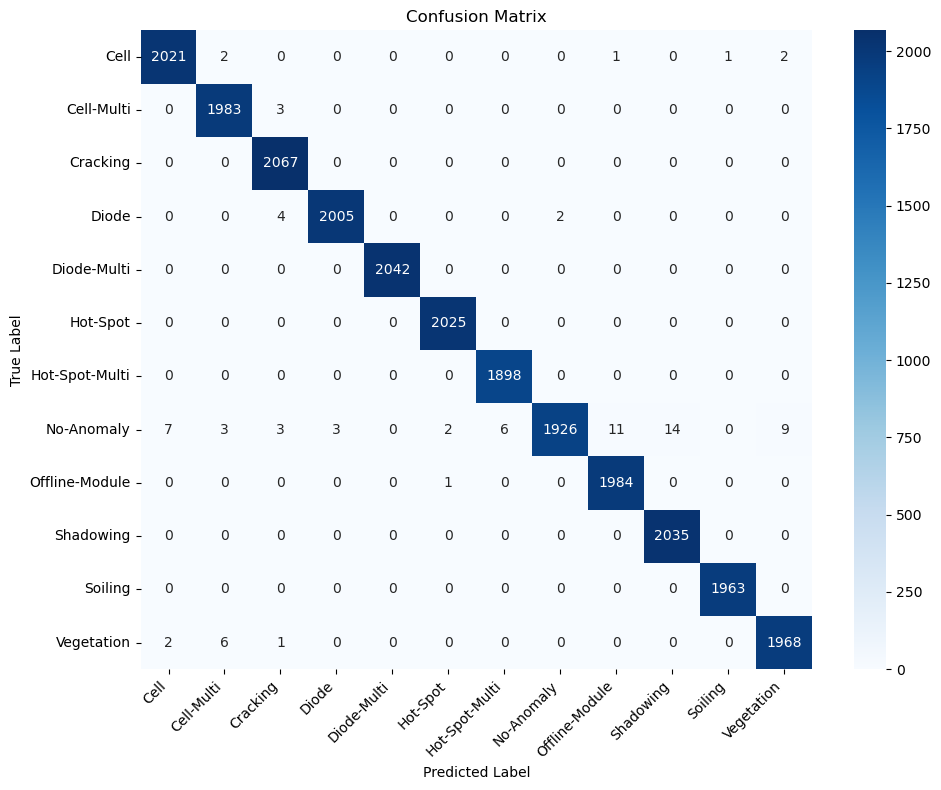

Saved metrics and confusion matrix to: artifacts\solar_cls_v1_20250822-203313\eval_artifacts


<Figure size 640x480 with 0 Axes>

In [37]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)


class_names = sorted(df['anomaly_class'].unique().tolist())

# Safety check for one-hot shape vs names
if y_test.shape[1] != len(class_names):
    print(f"[WARN] y_test has {y_test.shape[1]} classes, df has {len(class_names)} names.")
    # If you have a label_binarizer: class_names = list(label_binarizer.classes_)

# ===== C) Predict =====
# Ensure X_test preprocessing matches training (resizing, scaling, etc.)
y_pred = model.predict(X_test, batch_size=32)

# One-hot -> integer labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# ===== D) Core metrics =====
accuracy  = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='macro', zero_division=0)
recall    = recall_score(y_test_classes, y_pred_classes, average='macro', zero_division=0)
f1        = f1_score(y_test_classes, y_pred_classes, average='macro', zero_division=0)

# Top-3 accuracy (to mirror your Keras metric)
top3_idx = np.argsort(y_pred, axis=1)[:, -3:]
top3_acc = np.mean(np.any(top3_idx == y_test_classes[:, None], axis=1))

# ===== E) Specificity (macro) =====
cm = confusion_matrix(y_test_classes, y_pred_classes, labels=np.arange(len(class_names)))
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)
specificity_per_class = np.divide(TN, (TN + FP), out=np.zeros_like(TN, dtype=float), where=(TN+FP)!=0)
specificity_macro = np.mean(specificity_per_class)

# ===== F) ROC-AUC (macro OVR) =====
try:
    roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='macro')
except ValueError:
    # Happens if a class has only one label present in y_test
    roc_auc = float('nan')

# ===== G) Print summary =====
print("=== Evaluation Metrics ===")
print(f"Accuracy            : {accuracy:.4f}")
print(f"Top-3 Accuracy      : {top3_acc:.4f}")
print(f"Precision (macro)   : {precision:.4f}")
print(f"Recall (macro)      : {recall:.4f}")
print(f"F1-score (macro)    : {f1:.4f}")
print(f"Specificity (macro) : {specificity_macro:.4f}")
print(f"ROC-AUC (macro)     : {roc_auc:.4f}")

# ===== H) Detailed report =====
print("\n=== Classification Report ===")
print(classification_report(
    y_test_classes, y_pred_classes,
    target_names=class_names, zero_division=0
))

# ===== I) Confusion matrix heatmap =====
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names, yticklabels=class_names
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ===== J) (Optional) Save artifacts =====
out_dir = os.path.join(os.path.dirname(saved_dir), "eval_artifacts")
os.makedirs(out_dir, exist_ok=True)
with open(os.path.join(out_dir, "metrics.json"), "w") as f:
    json.dump({
        "accuracy": float(accuracy),
        "top3_accuracy": float(top3_acc),
        "precision_macro": float(precision),
        "recall_macro": float(recall),
        "f1_macro": float(f1),
        "specificity_macro": float(specificity_macro),
        "roc_auc_macro": float(roc_auc),
        "class_names": class_names
    }, f, indent=2)
plt.savefig(os.path.join(out_dir, "confusion_matrix.png"), dpi=200)
print("Saved metrics and confusion matrix to:", out_dir)

## ROC and Precision-Recall Curve

Macro ROC-AUC: 0.9999


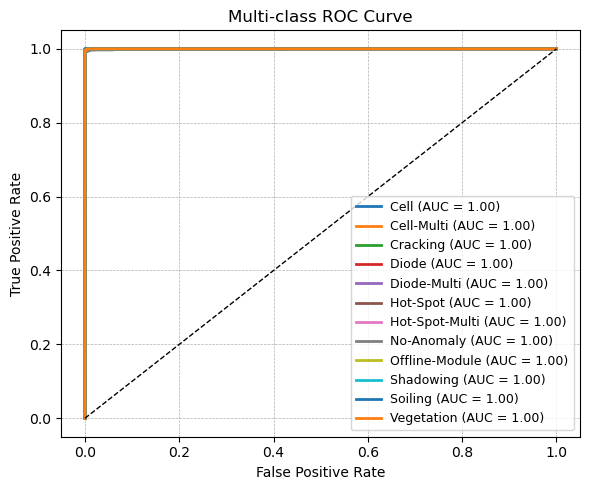

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns

# ===== Class names from your DataFrame =====
class_names = sorted(df['anomaly_class'].unique().tolist())

# Safety check: make sure counts match one-hot columns
n_classes = y_test.shape[1]
if len(class_names) != n_classes:
    print(f"[WARN] {n_classes} columns in y_test but {len(class_names)} names in df. Check ordering/mapping!")

# One-vs-Rest inputs
y_test_bin = y_test          # shape: (N, K) one-hot
y_pred_bin = y_pred          # shape: (N, K) probabilities

# ===== ROC-AUC (macro) =====
roc_auc_macro = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print(f"Macro ROC-AUC: {roc_auc_macro:.4f}")

# ===== Per-class ROC curves =====
fpr, tpr, roc_auc_per_class = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc_per_class[i] = auc(fpr[i], tpr[i])

# ===== Plot =====
plt.figure(figsize=(6, 5))
colors = cycle(plt.cm.tab10.colors)

for i, color in zip(range(n_classes), colors):
    label = f"{class_names[i]} (AUC = {roc_auc_per_class[i]:.2f})"
    plt.plot(fpr[i], tpr[i], lw=2, color=color, label=label)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('Multi-class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

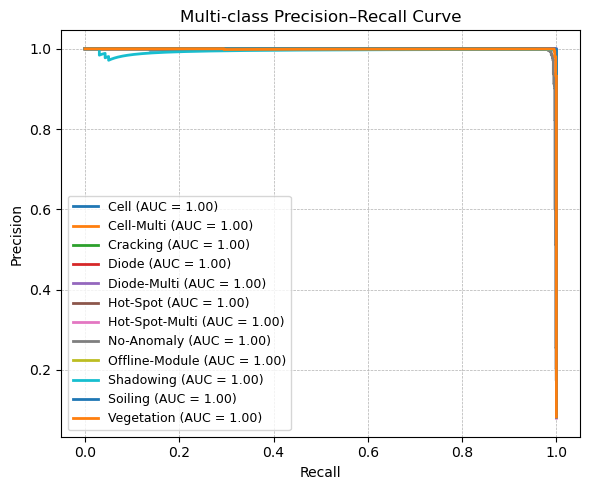

In [39]:
from sklearn.metrics import precision_recall_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt

# ===== Class names from your DataFrame =====
class_names = sorted(df['anomaly_class'].unique().tolist())

# Safety check
n_classes = y_test.shape[1]
if len(class_names) != n_classes:
    print(f"[WARN] y_test has {n_classes} classes but df has {len(class_names)} names.")
    print("       Check that the class order matches the one-hot encoding.")

# ===== Compute PR curve and AUC for each class =====
precision, recall, pr_auc = {}, {}, {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# ===== Plot all PR curves =====
plt.figure(figsize=(6, 5))
colors = cycle(plt.cm.tab10.colors)

for i, color in zip(range(n_classes), colors):
    label = f"{class_names[i]} (AUC = {pr_auc[i]:.2f})"
    plt.plot(recall[i], precision[i], color=color, lw=2, label=label)

plt.title('Multi-class Precision–Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left', fontsize=9)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Multiple Plotting

=== Evaluation ===
Accuracy            : 0.9965
Top-3 Accuracy      : 0.9995
Precision (macro)   : 0.9966
Recall (macro)      : 0.9965
F1-score (macro)    : 0.9965
Specificity (macro) : 0.9997
ROC-AUC (macro)     : 0.9999

=== Classification Report ===
                precision    recall  f1-score   support

          Cell       1.00      1.00      1.00      2027
    Cell-Multi       0.99      1.00      1.00      1986
      Cracking       0.99      1.00      1.00      2067
         Diode       1.00      1.00      1.00      2011
   Diode-Multi       1.00      1.00      1.00      2042
      Hot-Spot       1.00      1.00      1.00      2025
Hot-Spot-Multi       1.00      1.00      1.00      1898
    No-Anomaly       1.00      0.97      0.98      1984
Offline-Module       0.99      1.00      1.00      1985
     Shadowing       0.99      1.00      1.00      2035
       Soiling       1.00      1.00      1.00      1963
    Vegetation       0.99      1.00      0.99      1977

      accuracy   

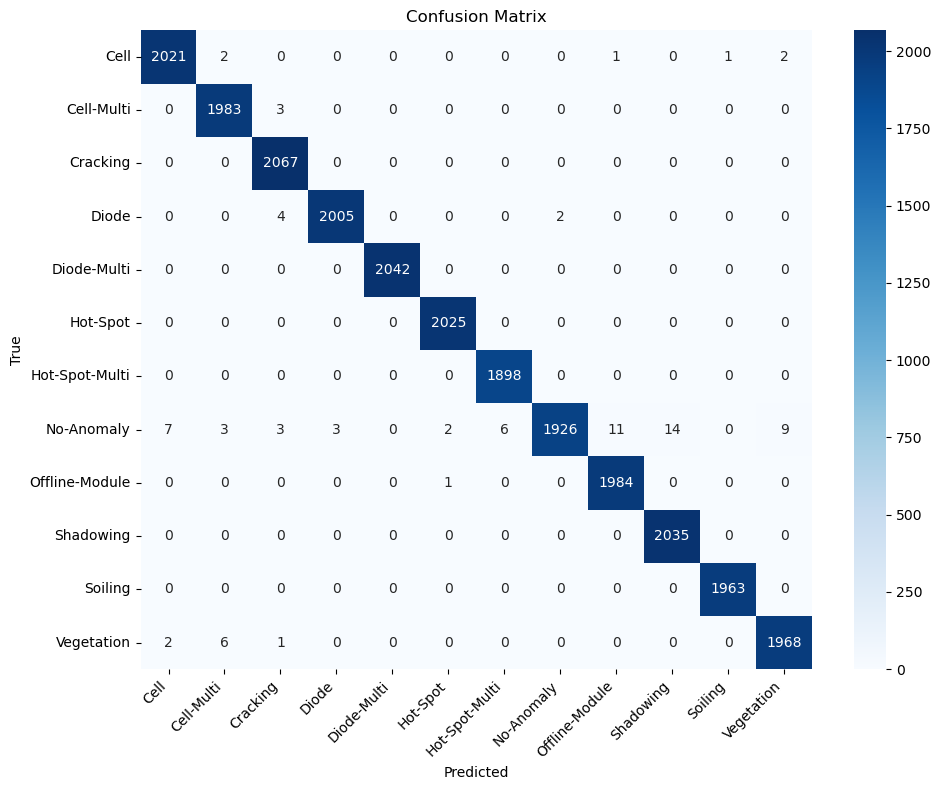

In [41]:
# ============================================
# 0) SETUP / COMMONS
# ============================================
import os, json, numpy as np, matplotlib.pyplot as plt, seaborn as sns, tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score)

# If you saved as SavedModel and don't have `model` in memory, load like this:
# saved_dir = r"path\to\your\run\saved_model"
# model = tf.keras.models.load_model(saved_dir, compile=False)

# Stable class order from your df (adjust if you have a label encoder)
class_names = sorted(df['anomaly_class'].unique().tolist())
num_classes = len(class_names)

# --- small helpers (Keras 2/3 safe) ---
def producing_layer(t):
    kh = getattr(t, "_keras_history", None)
    if kh is None: raise ValueError("Tensor has no _keras_history; cannot trace producer.")
    if isinstance(kh, tuple):  # TF/Keras 2.x
        return kh[0]
    return kh.layer  # Keras 3

def to_rgb(img):
    if img.ndim == 2: return np.stack([img, img, img], axis=-1)
    if img.shape[-1] == 1: return np.repeat(img, 3, axis=-1)
    return img

# ============================================
# 1) EVALUATION (adds top-3 + specificity + ROC-AUC)
# ============================================
def evaluate_model(model, X_test, y_test, class_names):
    y_pred = model.predict(X_test, batch_size=32, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    acc  = accuracy_score(y_test_classes, y_pred_classes)
    prec = precision_score(y_test_classes, y_pred_classes, average='macro', zero_division=0)
    rec  = recall_score(y_test_classes, y_pred_classes, average='macro', zero_division=0)
    f1   = f1_score(y_test_classes, y_pred_classes, average='macro', zero_division=0)

    # top-3
    top3_idx = np.argsort(y_pred, axis=1)[:, -3:]
    top3_acc = np.mean(np.any(top3_idx == y_test_classes[:, None], axis=1))

    # specificity (macro)
    cm = confusion_matrix(y_test_classes, y_pred_classes, labels=np.arange(len(class_names)))
    TP = np.diag(cm); FP = cm.sum(axis=0) - TP; FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (TP + FP + FN)
    spec_per_cls = np.divide(TN, (TN + FP), out=np.zeros_like(TN, dtype=float), where=(TN+FP)!=0)
    spec_macro = np.mean(spec_per_cls)

    # ROC-AUC macro
    try:
        roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='macro')
    except ValueError:
        roc_auc = float('nan')

    print("=== Evaluation ===")
    print(f"Accuracy            : {acc:.4f}")
    print(f"Top-3 Accuracy      : {top3_acc:.4f}")
    print(f"Precision (macro)   : {prec:.4f}")
    print(f"Recall (macro)      : {rec:.4f}")
    print(f"F1-score (macro)    : {f1:.4f}")
    print(f"Specificity (macro) : {spec_macro:.4f}")
    print(f"ROC-AUC (macro)     : {roc_auc:.4f}")

    print("\n=== Classification Report ===")
    print(classification_report(y_test_classes, y_pred_classes, target_names=class_names, zero_division=0))

    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
    plt.tight_layout(); plt.show()

    return {"acc": acc, "top3": top3_acc, "prec": prec, "rec": rec, "f1": f1,
            "spec": spec_macro, "roc_auc": roc_auc, "cm": cm}

_ = evaluate_model(model, X_test, y_test, class_names)


## Multiscale branch

Detected multi-scale join: concatenate_5
  - conv2d_59: kernel=(1, 1), filters=256
  - conv2d_60: kernel=(3, 3), filters=256
  - conv2d_61: kernel=(5, 5), filters=256


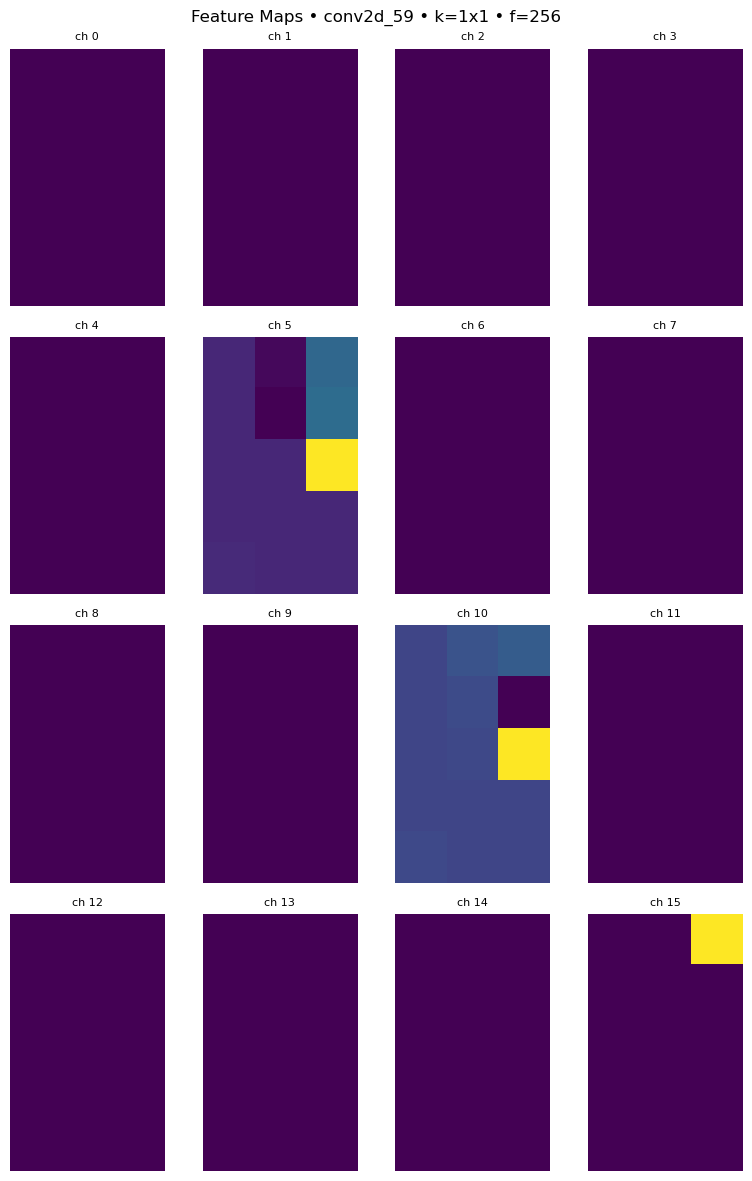

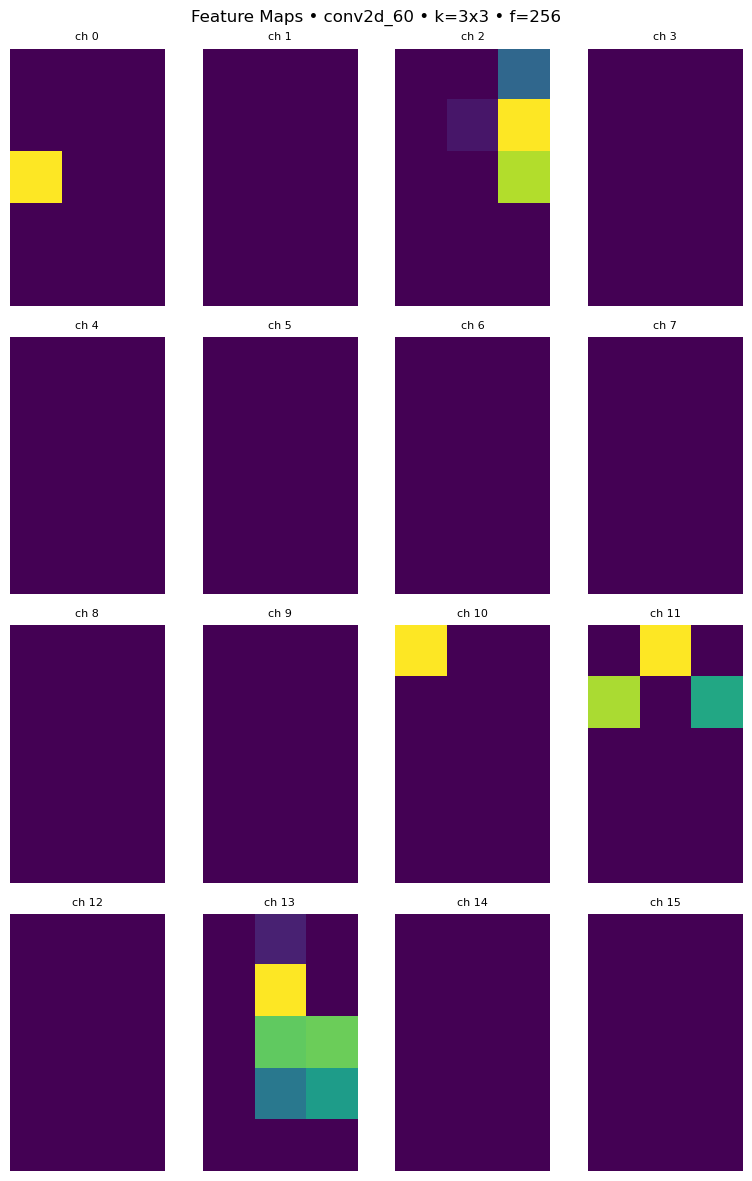

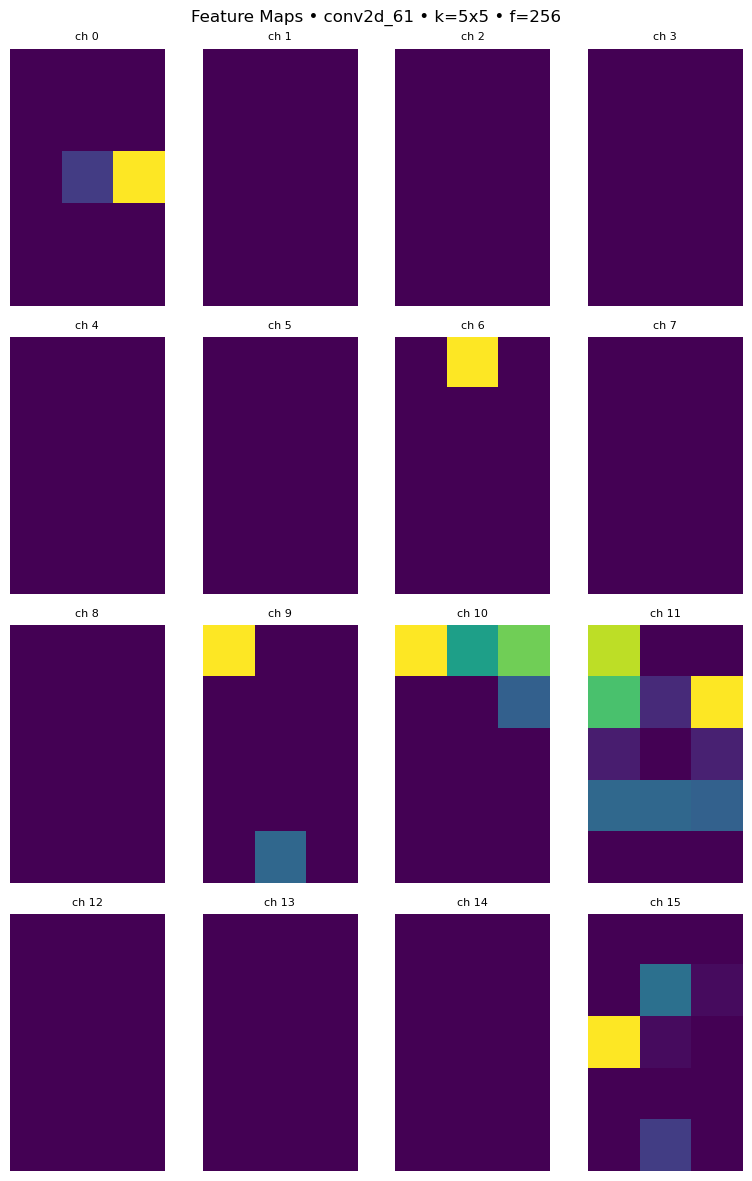

In [42]:
# ============================================
# 2) MULTI-SCALE CONCAT BRANCH MAPS (auto-detect)
# Works with your final 1x1/3x3/5x5 Concatenate head
# ============================================
def find_multiscale_concat(model):
    concats = [l for l in model.layers if isinstance(l, tf.keras.layers.Concatenate)]
    if not concats: raise ValueError("No Concatenate layers found.")
    scored = []
    for c in concats:
        ins = c.input if isinstance(c.input, (list, tuple)) else [c.input]
        n_in = len(ins)
        outC = int(c.output.shape[-1]) if c.output.shape[-1] is not None else 0
        scored.append((n_in, outC, c, ins))
    scored.sort(key=lambda x: (x[0], x[1]), reverse=True)
    return scored[0][2], scored[0][3]   # concat_layer, inbound_tensors

def get_multiscale_branch_convs(model):
    concat, ins = find_multiscale_concat(model)
    inbound_layers = [producing_layer(t) for t in ins]
    branch_convs = [l for l in inbound_layers if isinstance(l, tf.keras.layers.Conv2D)]
    if len(branch_convs) < 2:
        raise ValueError(f"Expected multiple Conv2D branches into {concat.name}, got {[l.name for l in inbound_layers]}")
    # sort by kernel size (so: 1x1, 3x3, 5x5)
    branch_convs = sorted(branch_convs, key=lambda L: (L.kernel_size[0], L.kernel_size[1]))
    return branch_convs, concat

def plot_feature_maps_grid(maps, title, max_channels=16):
    fmap = maps[0]  # (H, W, C)
    C = fmap.shape[-1]
    k = min(C, max_channels)
    cols = int(np.ceil(np.sqrt(k))); rows = int(np.ceil(k/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 3*rows))
    axes = np.atleast_2d(axes)
    for i in range(rows*cols):
        r,c = divmod(i, cols)
        ax = axes[r,c]
        if i < k:
            ax.imshow(fmap[..., i], cmap='viridis'); ax.set_title(f"ch {i}", fontsize=8)
        ax.axis('off')
    plt.suptitle(title, fontsize=12); plt.tight_layout(); plt.show()

branch_convs, concat_layer = get_multiscale_branch_convs(model)
print("Detected multi-scale join:", concat_layer.name)
for L in branch_convs:
    print(f"  - {L.name}: kernel={L.kernel_size}, filters={L.filters}")

# inspect a random sample
idx = np.random.randint(0, X_test.shape[0])
sample = X_test[idx:idx+1]

multi_out_model = Model(inputs=model.input, outputs=[L.output for L in branch_convs])
feature_maps_list = multi_out_model.predict(sample, verbose=0)

for L, fmap in zip(branch_convs, feature_maps_list):
    ks = f"{L.kernel_size[0]}x{L.kernel_size[1]}"
    title = f"Feature Maps • {L.name} • k={ks} • f={L.filters}"
    plot_feature_maps_grid(fmap, title, max_channels=16)


## Dual attention branch

Spatial attention Multiply layers: ['multiply_5', 'multiply_7']


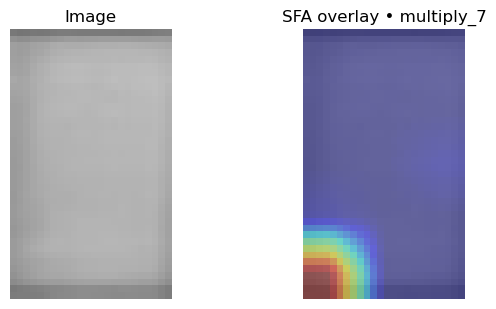

In [ ]:
# ============================================
# 3) SPATIAL ATTENTION OVERLAYS (auto-detect dual_attention_block)
# Detect Multiply where one input is Conv2D(filters=1, k=7) -> spatial mask
# ============================================
import matplotlib.cm as cm

def find_spatial_attention_multiplies(model):
    hits = []
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Multiply):
            ins = layer.input if isinstance(layer.input, (list, tuple)) else [layer.input]
            prod_layers = [producing_layer(t) for t in ins]
            # spatial branch: Conv2D with 1 filter (sigmoid)
            for L in prod_layers:
                if isinstance(L, tf.keras.layers.Conv2D) and getattr(L, "filters", None) == 1:
                    hits.append((layer.name, layer.output, L.output))  # (multiply, multiplied_feat, spatial_mask)
                    break
    return hits  # [(name, mult_out, mask_out), ...]

def overlay(img, heatmap, alpha=0.45):
    img = img.astype("float32")
    if img.max() > 1.0: img = img/255.0
    rgb = to_rgb(img)
    heat_rgb = cm.jet(heatmap)[..., :3]
    return (alpha*heat_rgb + (1-alpha)*rgb).clip(0,1)

def make_heatmap(att_feats, out_hw, mode="mean"):
    # att_feats: (H, W, C) after Multiply (features * spatial mask)
    if mode == "max": h2d = np.max(att_feats, axis=-1)
    else:             h2d = np.mean(att_feats, axis=-1)
    h2d = np.maximum(h2d, 0); h2d = h2d / (h2d.max() + 1e-8)
    h2d = tf.image.resize(h2d[..., None], out_hw, method="bilinear").numpy()[...,0]
    return h2d

# choose a sample
idx = np.random.randint(0, X_test.shape[0])
sample = X_test[idx:idx+1]; img0 = sample[0]
H,W = img0.shape[0], img0.shape[1]

sfa = find_spatial_attention_multiplies(model)
if not sfa:
    raise RuntimeError("No spatial-attention Multiply layers found. Check dual_attention_block.")
print("Spatial attention Multiply layers:", [n for n,_,_ in sfa])

# visualize last spatial attention
name, mult_tensor, mask_tensor = sfa[-1]
att_model = Model(inputs=model.input, outputs=mult_tensor)  # post-multiply feature
att_feats = att_model.predict(sample, verbose=0)[0]         # (h,w,c)
heat = make_heatmap(att_feats, (H,W), mode="mean")
ov = overlay(img0, heat, alpha=0.45)

fig, axes = plt.subplots(1,2, figsize=(7,3.2))
axes[0].imshow(to_rgb(img0)); axes[0].set_title("Image"); axes[0].axis("off")
axes[1].imshow(ov);           axes[1].set_title(f"SFA overlay • {name}"); axes[1].axis("off")
plt.tight_layout(); plt.show()

Multiply layers: ['multiply_4', 'multiply_5', 'multiply_6', 'multiply_7']


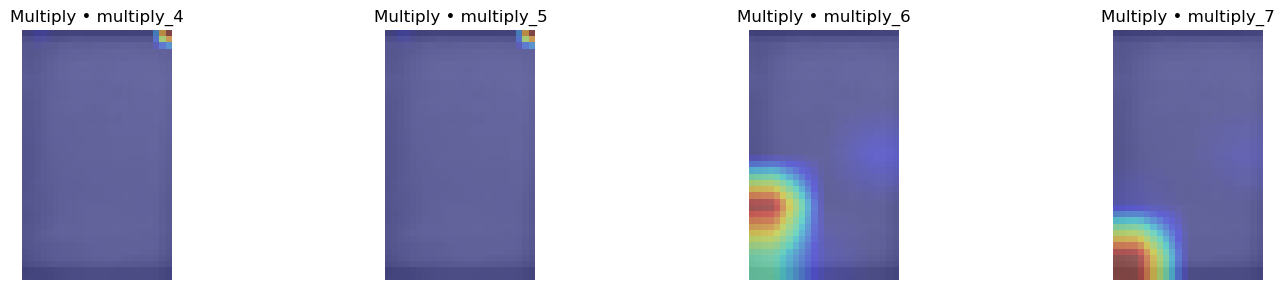

In [44]:
# ============================================
# 4) ATTENTION OVERLAYS FOR *ALL* Multiply LAYERS (auto)
# (These are post-attention feature maps, aggregated to heatmaps)
# ============================================
multiply_layers = [l.name for l in model.layers if isinstance(l, tf.keras.layers.Multiply)]
print("Multiply layers:", multiply_layers)

# Build a multi-output model on all Multiply layers
outs = [model.get_layer(n).output for n in multiply_layers]
att_model_all = Model(inputs=model.input, outputs=outs)
att_feats_list = att_model_all.predict(sample, verbose=0)  # list of (1,h,w,c)

n = len(multiply_layers)
fig, axes = plt.subplots(1, n, figsize=(4*n, 3), squeeze=False)
for i, (name, feats) in enumerate(zip(multiply_layers, att_feats_list)):
    heat = make_heatmap(feats[0], (H,W), mode="mean")
    ax = axes[0, i]
    ax.imshow(overlay(img0, heat, alpha=0.45))
    ax.set_title(f"Multiply • {name}"); ax.axis("off")
plt.tight_layout(); plt.show()


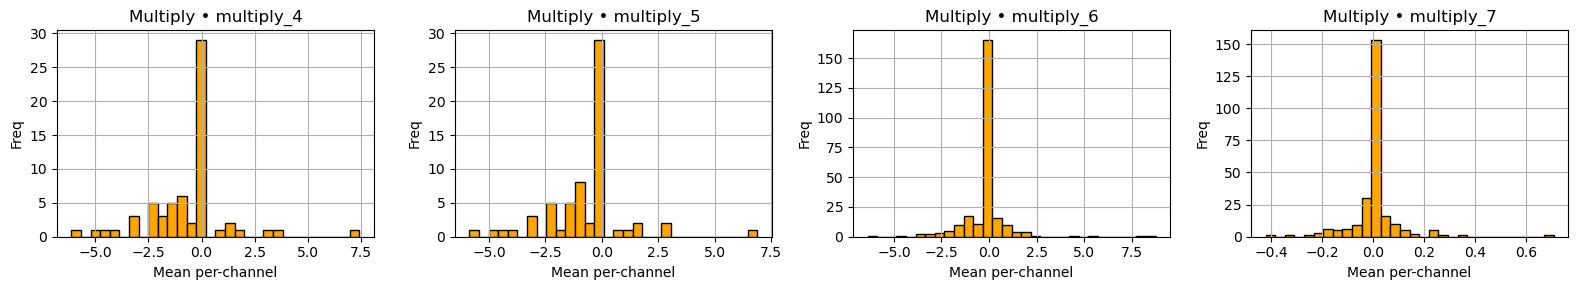

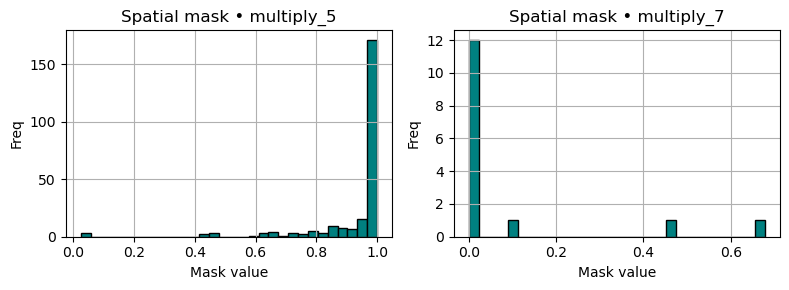

In [45]:
# ============================================
# 5) ATTENTION HISTOGRAMS
# (a) hist of post-attention feature amplitudes at Multiply outputs
# (b) hist of *spatial masks* (Conv2D(1,7)) if present
# ============================================
# (a) Multiply output histograms
n = len(multiply_layers)
fig, axes = plt.subplots(1, n, figsize=(4*n, 3), squeeze=False)
for i, (name, feats) in enumerate(zip(multiply_layers, att_feats_list)):
    att_vec = np.mean(feats[0], axis=(0,1))   # (C,)
    ax = axes[0, i]
    ax.hist(att_vec, bins=30, color='orange', edgecolor='black')
    ax.set_title(f"Multiply • {name}"); ax.set_xlabel("Mean per-channel"); ax.set_ylabel("Freq"); ax.grid(True)
plt.tight_layout(); plt.show()

# (b) spatial mask histograms (true attention masks)
sfa = find_spatial_attention_multiplies(model)
if sfa:
    fig, axes = plt.subplots(1, len(sfa), figsize=(4*len(sfa), 3), squeeze=False)
    for i, (name, _, mask_tensor) in enumerate(sfa):
        m_model = Model(inputs=model.input, outputs=mask_tensor)
        mask = m_model.predict(sample, verbose=0)[0]  # (h,w,1)
        ax = axes[0, i]
        ax.hist(mask.ravel(), bins=30, color='teal', edgecolor='black')
        ax.set_title(f"Spatial mask • {name}"); ax.set_xlabel("Mask value"); ax.set_ylabel("Freq"); ax.grid(True)
    plt.tight_layout(); plt.show()


## GradCam

Conv2D layers: ['conv2d_31', 'conv2d_32', 'conv2d_33', 'conv2d_34', 'conv2d_35', 'conv2d_36', 'conv2d_38', 'conv2d_37', 'conv2d_39', 'conv2d_40', 'conv2d_41', 'conv2d_42', 'conv2d_43', 'conv2d_44', 'conv2d_46', 'conv2d_45', 'conv2d_47', 'conv2d_48', 'conv2d_49', 'conv2d_50', 'conv2d_51', 'conv2d_53', 'conv2d_52', 'conv2d_54', 'conv2d_55', 'conv2d_56', 'conv2d_57', 'conv2d_58', 'conv2d_59', 'conv2d_60', 'conv2d_61']
Using last Conv2D: conv2d_61
Selected indices: [2237, 18529, 15646, 9805, 10394, 20449, 2111, 16573, 5374, 2317, 12675, 23215] for classes: [ 0  1  2  3  4  5  6  7  8  9 10 11]


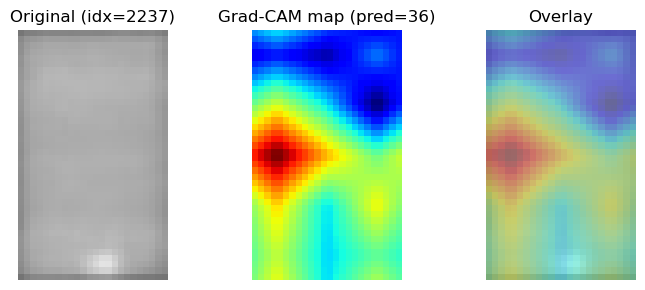

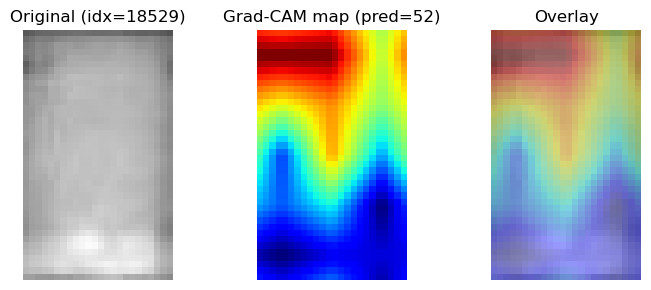

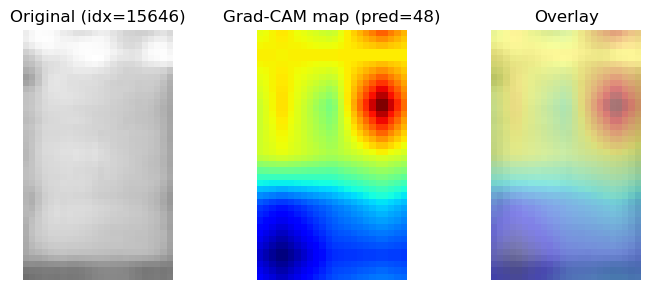

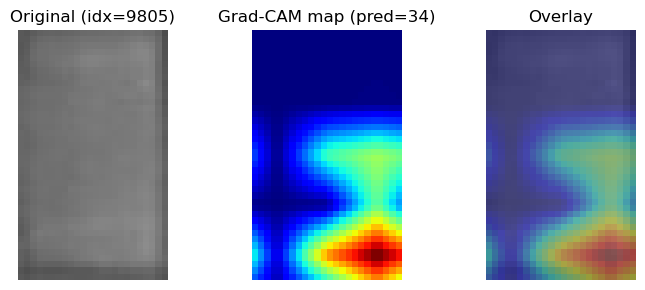

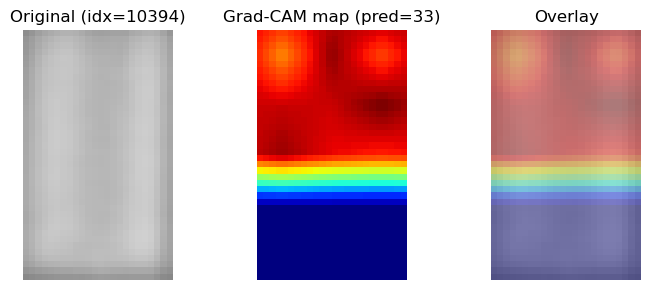

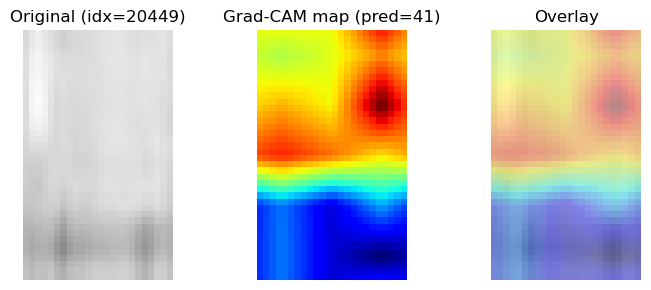

Also trying earlier Conv2D: conv2d_60


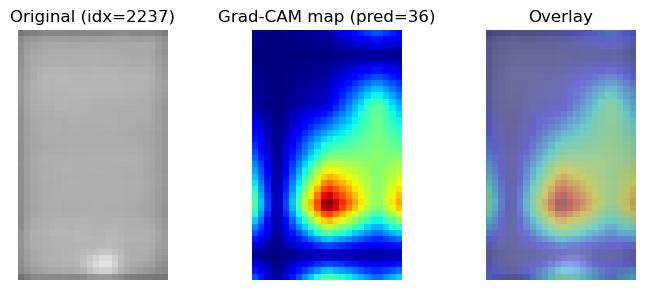

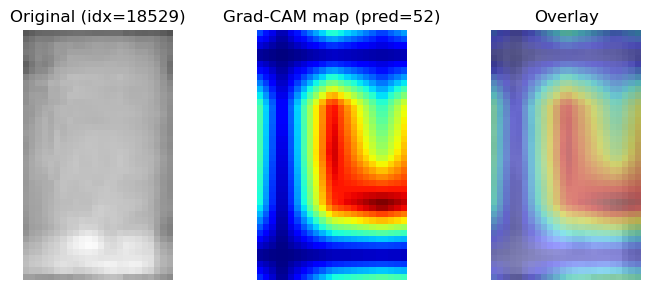

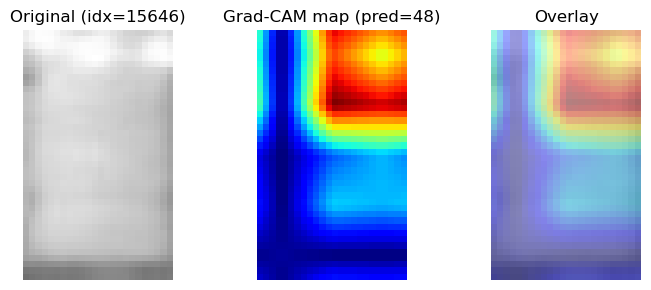

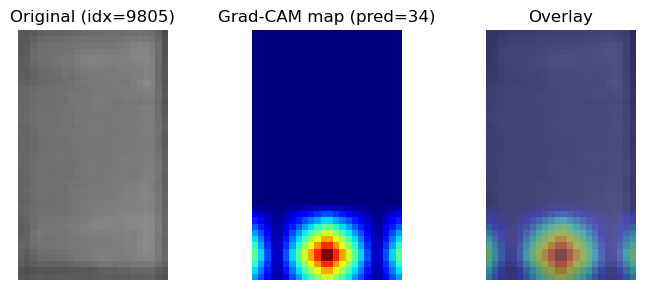

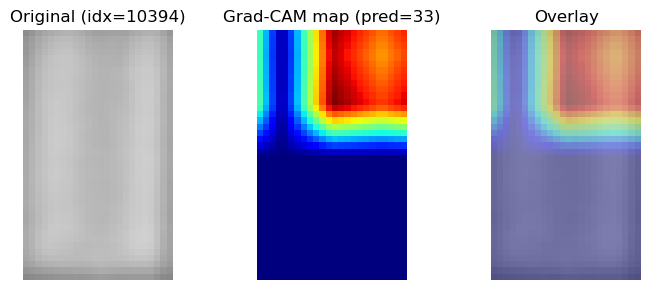

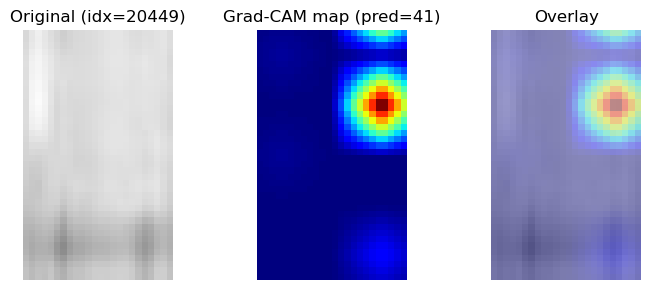

In [46]:
# ============================================
# 6) Grad-CAM (auto-picks last Conv2D; try earlier conv if too coarse)
# ============================================
from skimage.transform import resize
import matplotlib.cm as cm

def list_conv2d_layers(model):
    return [l.name for l in model.layers if isinstance(l, tf.keras.layers.Conv2D)]

def find_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found.")

def get_logits_model(model):
    last = model.layers[-1]
    try:
        return tf.keras.Model(inputs=model.inputs, outputs=last.input)
    except Exception:
        return model

def make_gradcam_heatmap(img_array, model, last_conv_layer_name=None, pred_index=None):
    if last_conv_layer_name is None:
        last_conv_layer_name = find_last_conv_layer_name(model)
    logits_model = get_logits_model(model)
    conv_out = model.get_layer(last_conv_layer_name).output
    grad_model = tf.keras.Model(inputs=model.inputs, outputs=[conv_out, logits_model.output])
    with tf.GradientTape() as tape:
        conv_outputs, logits = grad_model(img_array, training=False)
        if pred_index is None: pred_index = tf.argmax(logits[0])
        loss = logits[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)[0]      # (hc,wc,C)
    pooled = tf.reduce_mean(grads, axis=(0,1))        # (C,)
    conv_outputs = conv_outputs[0]                    # (hc,wc,C)
    heatmap = tf.reduce_sum(conv_outputs * pooled, axis=-1)
    heatmap = tf.nn.relu(heatmap); heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy(), int(pred_index.numpy())

def overlay_heatmap_on_image(img, heatmap, alpha=0.40):
    img = img.astype("float32"); 
    if img.max() > 1.0: img = img/255.0
    rgb = to_rgb(img); heat_rgb = cm.jet(heatmap)[..., :3]
    return (alpha*heat_rgb + (1-alpha)*rgb).clip(0,1)

# one sample per class (optional helper)
def one_sample_per_class_indices(y_onehot, max_classes=None, seed=42):
    y_cls = np.argmax(y_onehot, axis=1); classes = np.unique(y_cls)
    if max_classes is not None: classes = classes[:max_classes]
    rng = np.random.default_rng(seed); idxs = []
    for c in classes:
        ids = np.where(y_cls == c)[0]
        if len(ids): idxs.append(ids[rng.integers(0, len(ids))])
    return idxs, classes

print("Conv2D layers:", list_conv2d_layers(model))
last_conv = find_last_conv_layer_name(model)
print("Using last Conv2D:", last_conv)

idxs, classes = one_sample_per_class_indices(y_test, max_classes=None, seed=42)
print("Selected indices:", idxs, "for classes:", classes)

# visualize Grad-CAM for selected indices
for idx in idxs[:min(6, len(idxs))]:
    img = X_test[idx]
    heat_small, pred = make_gradcam_heatmap(img[None, ...], model, last_conv_layer_name=last_conv)
    heat = resize(heat_small, (img.shape[0], img.shape[1]), preserve_range=True)
    heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)
    overlay_img = overlay_heatmap_on_image(img, heat, alpha=0.40)

    fig, axes = plt.subplots(1,3, figsize=(7.5,3))
    axes[0].imshow(to_rgb(img)); axes[0].set_title(f"Original (idx={idx})"); axes[0].axis("off")
    axes[1].imshow(cm.jet(heat)[..., :3]); axes[1].set_title(f"Grad-CAM map (pred={pred})"); axes[1].axis("off")
    axes[2].imshow(overlay_img); axes[2].set_title("Overlay"); axes[2].axis("off")
    plt.tight_layout(); plt.show()

# Try an earlier conv if needed:
conv_names = list_conv2d_layers(model)
if len(conv_names) >= 2:
    earlier = conv_names[-2]
    print("Also trying earlier Conv2D:", earlier)
    for idx in idxs[:min(6, len(idxs))]:
        img = X_test[idx]
        heat_small, pred = make_gradcam_heatmap(img[None, ...], model, last_conv_layer_name=earlier)
        heat = resize(heat_small, (img.shape[0], img.shape[1]), preserve_range=True)
        heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)
        overlay_img = overlay_heatmap_on_image(img, heat, alpha=0.40)
        fig, axes = plt.subplots(1,3, figsize=(7.5,3))
        axes[0].imshow(to_rgb(img)); axes[0].set_title(f"Original (idx={idx})"); axes[0].axis("off")
        axes[1].imshow(cm.jet(heat)[..., :3]); axes[1].set_title(f"Grad-CAM map (pred={pred})"); axes[1].axis("off")
        axes[2].imshow(overlay_img); axes[2].set_title("Overlay"); axes[2].axis("off")
        plt.tight_layout(); plt.show()


## Dense

Penultimate Dense: dense_8


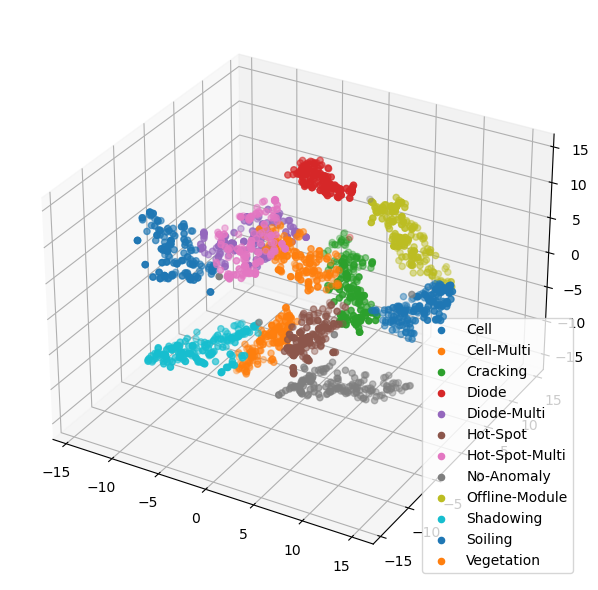

In [47]:
# ============================================
# 7) t-SNE on penultimate Dense (auto-detect layer)
# ============================================
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # noqa

def find_penultimate_dense_name(model, num_classes):
    dense_layers = [l for l in model.layers if isinstance(l, tf.keras.layers.Dense)]
    if not dense_layers: raise ValueError("No Dense layers found.")
    # try to find final classifier
    final_candidates = [l for l in dense_layers
                        if l.units == num_classes or getattr(l.activation, "__name__", "") == "softmax"]
    if final_candidates:
        final = final_candidates[-1]
        dnames = [l.name for l in dense_layers]
        idx = dnames.index(final.name)
        if idx > 0: return dense_layers[idx-1].name
    # fallback: second last Dense
    return dense_layers[-2].name if len(dense_layers) >= 2 else dense_layers[-1].name

penult = find_penultimate_dense_name(model, num_classes)
print("Penultimate Dense:", penult)

# Subsample for speed
max_points = 2000; rng = np.random.default_rng(42)
N = X_test.shape[0]
sel = rng.choice(N, size=min(N, max_points), replace=False)

feat_model = Model(inputs=model.input, outputs=model.get_layer(penult).output)
features = feat_model.predict(X_test[sel], verbose=0)
labels = np.argmax(y_test[sel], axis=1)

# 3D t-SNE (you can switch to 2D)
tsne = TSNE(n_components=3, perplexity=30, n_iter=500, random_state=42, init="pca")
emb3 = tsne.fit_transform(features)

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
for c in np.unique(labels):
    m = labels == c
    ax.scatter(emb3[m,0], emb3[m,1], emb3[m,2], s=20, label=class_names[c])
ax.legend(); plt.tight_layout(); plt.show()


[INFO] Skipping missing layer: dense_1
[INFO] Skipping missing layer: dense_2
[INFO] Skipping missing layer: dense_3
[INFO] Skipping missing layer: dense_4


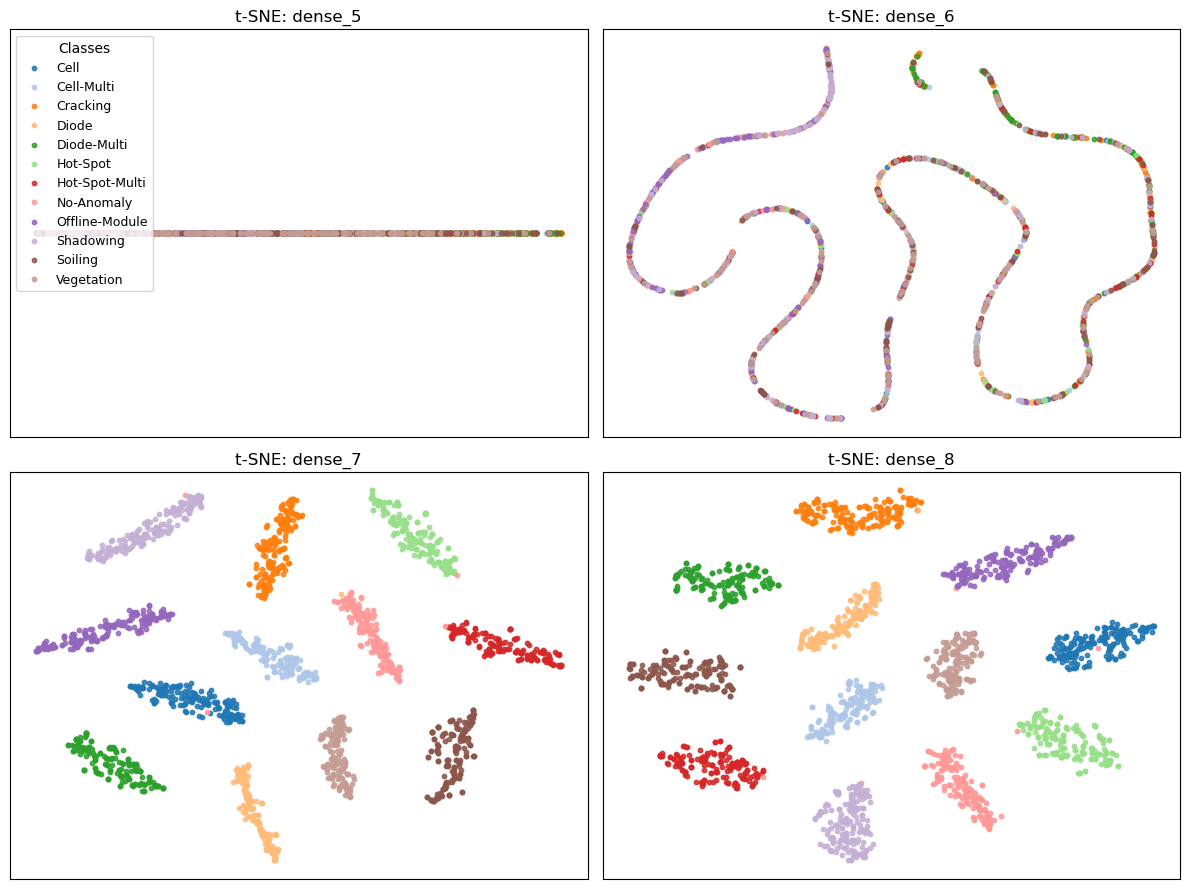

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model
import tensorflow as tf
import matplotlib.cm as cm

# ========= Config =========
max_points = 2000
tsne_perplexity = 30
tsne_iter = 500
random_state = 42
layer_names = [f"dense_{i}" for i in range(1, 9)]  # dense_1 ... dense_8 (preferred naming)

# ========= Class names =========
class_names = sorted(df['anomaly_class'].unique().tolist())
y_true = np.argmax(y_test, axis=1)
n_classes = len(class_names)

if y_test.shape[1] != n_classes:
    print(f"[WARN] y_test has {y_test.shape[1]} classes but df reports {n_classes}.")
    print("      Ensure class order matches your one-hot encoding.")

# ========= Subsample =========
N = X_test.shape[0]
rng = np.random.default_rng(random_state)
if max_points is not None and N > max_points:
    sel = rng.choice(N, size=max_points, replace=False)
else:
    sel = np.arange(N)

X_sel = X_test[sel]
y_sel = y_true[sel]

# ========= Colors =========
base_colors = list(cm.tab20.colors)
color_list = (base_colors * ((n_classes // len(base_colors)) + 1))[:n_classes]
colors = np.array(color_list)

# ========= Multi-output model =========
# Try requested names first; if none found, auto-discover Dense layers
present_layers = []
outputs = []
for name in layer_names:
    try:
        lyr = model.get_layer(name)
        outputs.append(lyr.output)
        present_layers.append(name)
    except Exception:
        print(f"[INFO] Skipping missing layer: {name}")

if not outputs:
    # Fallback: collect all Dense layers in forward order (excluding final softmax by default)
    dense_layers = [l for l in model.layers if isinstance(l, tf.keras.layers.Dense)]
    if not dense_layers:
        raise RuntimeError("No Dense layers found in the model.")
    # You can choose to include all dense layers; here we include all of them:
    present_layers = [l.name for l in dense_layers]
    outputs = [l.output for l in dense_layers]
    print("[INFO] Using auto-discovered Dense layers:", present_layers)

feat_model = Model(inputs=model.input, outputs=outputs)

# ========= Feature extraction =========
features_list = feat_model.predict(X_sel, verbose=0)

# ========= t-SNE + plot =========
# Safety clamp for perplexity: must be < (#points - 1)/3
safe_perp = min(tsne_perplexity, max(5, (len(X_sel) - 1) // 3))
if safe_perp != tsne_perplexity:
    print(f"[INFO] Adjusted perplexity from {tsne_perplexity} to {safe_perp} for {len(X_sel)} points.")

n_layers = len(present_layers)
n_cols = 2
n_rows = int(np.ceil(n_layers / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4.5*n_rows))
axes = np.atleast_2d(axes)

for i, (name, feats) in enumerate(zip(present_layers, features_list)):
    # Ensure 2D: (num_points, feature_dim)
    feats_2d = feats.reshape(feats.shape[0], -1)

    tsne = TSNE(
        n_components=2,
        perplexity=safe_perp,
        n_iter=tsne_iter,
        random_state=random_state,
        init="pca",
        learning_rate="auto"
    )
    emb = tsne.fit_transform(feats_2d)

    r, c = divmod(i, n_cols)
    ax = axes[r, c]
    for cls in np.unique(y_sel):
        mask = (y_sel == cls)
        ax.scatter(emb[mask, 0], emb[mask, 1],
                   s=10, alpha=0.85, color=colors[cls],
                   label=class_names[cls] if i == 0 else None)

    ax.set_title(f"t-SNE: {name}")
    ax.set_xticks([]); ax.set_yticks([])
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)

# Legend in top-left of first subplot
axes[0, 0].legend(
    title="Classes", loc='upper left',
    bbox_to_anchor=(0, 1), fontsize=9
)

# Hide unused axes
for j in range(i+1, n_rows*n_cols):
    r, c = divmod(j, n_cols)
    axes[r, c].axis('off')

# plt.suptitle("t-SNE Dense (dense_1 … dense_8)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()